# Business Impact Questions In Depth


This notebook provides a comprehensive analysis of the sales pipeline, including pipeline optimization, revenue forecasting, performance benchmarking, and product-market optimization.

## Data Import

This cell imports the necessary library (`pandas`) and loads the cleaned CRM and sales pipeline data from the file `CRM-and-Sales-Pipelines_cleaned.csv` into a DataFrame named `df`. It then displays the first few rows of the dataset using `df.head()`, allowing for a quick inspection of the data structure and contents.

In [10]:
import pandas as pd
df = pd.read_csv('CRM-and-Sales-Pipelines_cleaned.csv')
df.head()


,Organization,Country,Latitude,Longitude,Industry,Organization_size,Owner,Lead_acquisition_date,Product,Status,Status_sequence,Stage,Stage_sequence,Deal_Value_USD,Probability_Pct,Expected_close_date,Actual_close_date
0,Thoughtblab,Netherlands,52.370216,4.895168,Banking and Finance,Small (11-200),John Smith,4/20/2024,SAAS,Churned Customer,7,NaN,NaN,833,90,8/7/2024,6/27/2024
1,Jaxnation,Spain,40.416775,-3.703790,Energy & Utilities,Small (11-200),Emily Johnson,5/28/2024,SAAS,Churned Customer,7,NaN,NaN,1623,30,10/25/2024,9/11/2024
2,Mybuzz,Italy,41.902782,12.496366,Education & Science,Small (11-200),Michael Brown,3/17/2024,SAAS,Churned Customer,7,NaN,NaN,1928,20,3/17/2025,5/11/2024
3,Kare,Germany,52.520008,13.404954,Government Administration Healthcare,Small (11-200),Michael Brown,1/18/2024,SAAS,Churned Customer,7,NaN,NaN,303,50,8/7/2024,5/6/2024
4,Skaboo,Germany,52.520008,13.404954,Energy & Utilities,Small (11-200),Michael Brown,4/6/2024,SAAS,Churned Customer,7,NaN,NaN,1911,30,10/11/2024,7/25/2024


## Pipeline Optimization

**Question:**  
What does my current sales pipeline look like and how can it be optimized?

**Approach:**  
To answer this, we analyzed the sales pipeline data by focusing on records where the `Status` is "Opportunity". For each country, we calculated:
- The total number of opportunities (i.e., deals currently in the "Opportunity" stage). There are **867** or **28.9%** opportunities in total.
- The percentage of opportunities relative to all records for that country (i.e., opportunities divided by the total number of records for that country, across all stages).

We then highlighted the top 5 countries with the highest number of opportunities: **Italy, Germany, France, Switzerland, and Portugal** (replace with your actual top 5 if different). This helps identify markets where the sales pipeline is most opportunity-rich relative to overall activity, which can inform targeted optimization efforts.

Country,Total Records,Percentage,Opportunities
Italy,620,27.9%,173
Germany,420,29.5%,124
France,422,29.1%,123
Switzerland,392,27.8%,109
Portugal,371,28.6%,106


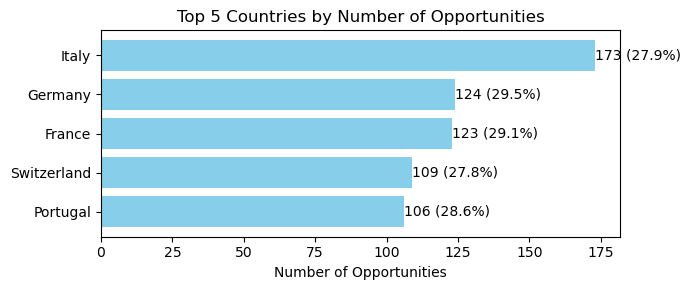

In [11]:
import pandas as pd
from IPython.display import display, HTML

# Count total records for each country (all stages)
total_by_country = df['Country'].value_counts().reset_index()
total_by_country.columns = ['Country', 'Total Records']

# Count opportunities for each country
opps_by_country = df[df['Status'] == 'Opportunity']['Country'].value_counts().reset_index()
opps_by_country.columns = ['Country', 'Opportunities']

# Merge the two DataFrames
merged = pd.merge(total_by_country, opps_by_country, on='Country', how='left').fillna(0)
merged['Opportunities'] = merged['Opportunities'].astype(int)

# Calculate percentage and format as '29.1%'
merged['Percentage'] = (merged['Opportunities'] / merged['Total Records']) * 100
merged['Percentage'] = merged['Percentage'].map('{:.1f}%'.format)

# Reorder columns: Country, Total Records, Percentage, Opportunities
final = merged[['Country', 'Total Records', 'Percentage', 'Opportunities']]

# Sort by Opportunities descending and get top 5
final = final.sort_values('Opportunities', ascending=False).head(5).reset_index(drop=True)

# Center all columns
styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]

display(HTML(final.style.set_table_styles(styles).hide(axis='index').to_html()))

import matplotlib.pyplot as plt

# Plotting the top 5 countries by opportunities
plt.figure(figsize=(7, 3))
plt.barh(final['Country'], final['Opportunities'], color='skyblue')
plt.xlabel('Number of Opportunities')
plt.title('Top 5 Countries by Number of Opportunities')
for i, (opp, pct) in enumerate(zip(final['Opportunities'], final['Percentage'])):
    plt.text(opp, i, f'{opp} ({pct})', va='center', fontsize=10)
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

## Revenue Forecasting

**Question:**  
What is the sales forecast accuracy for strategic planning?

**Approach:**  
To provide a clear and objective view of the sales pipeline for strategic planning, I analyzed the total value of all deals expected to close in each quarter. This analysis uses only the `Deal_Value_USD` and the `Expected_close_date` columns from the CRM data, grouping deals by the quarter of their expected close date.

I chose not to use probability-weighted values (`Probability_Pct`) in this forecast. Probability estimates can vary significantly between deals and sales representatives, introducing subjectivity and potential inconsistency. By focusing on the gross pipeline value, this approach offers a transparent and easily interpretable view of the sales pipeline, which is especially useful for high-level business planning and communication.


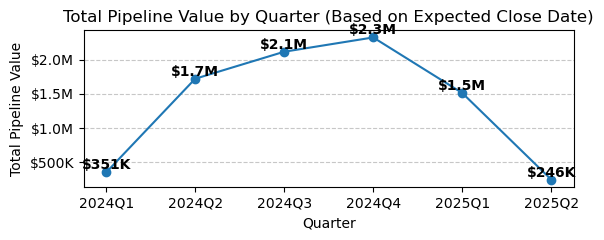

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Ensure date is parsed and quarter is extracted
df['Expected_close_date'] = pd.to_datetime(df['Expected_close_date'], errors='coerce')
df['Quarter'] = df['Expected_close_date'].dt.to_period('Q')

# Group by quarter and sum deal value
gross_by_quarter = df.groupby('Quarter')['Deal_Value_USD'].sum().reset_index()
gross_by_quarter['Quarter'] = gross_by_quarter['Quarter'].astype(str)

# Function to format currency in $12K, $1M, etc.
def currency_format(x, pos):
    if x >= 1_000_000:
        return f'${x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'${x/1_000:.0f}K'
    else:
        return f'${x:,.0f}'

plt.figure(figsize=(6, 2.5))
plt.plot(gross_by_quarter['Quarter'], gross_by_quarter['Deal_Value_USD'], marker='o', label='Total Pipeline Value')

# Annotate each point with formatted value
for i, v in enumerate(gross_by_quarter['Deal_Value_USD']):
    plt.text(i, v, currency_format(v, None), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Total Pipeline Value by Quarter (Based on Expected Close Date)')
plt.xlabel('Quarter')
plt.ylabel('Total Pipeline Value')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Performance Benchmarking

**Question:**  
What are the actual win rate benchmarks for competitive positioning?

**Approach:**  
To answer this, I defined a “win” as any deal where the `Stage` is "Won". For the denominator, I considered only opportunities—specifically, records where `Status` is "Opportunity". I calculated:
- The top 5 countries by number of wins: **Italy, Germany, France, Belgium, and Spain** 
- The total number of wins across all opportunities.
- The overall win rate, defined as the percentage of wins out of all opportunities (`Status == "Opportunity"`).


• **Status Column Analysis**: The CSV `Status` column shows 9.6% win rate (83 wins from 867 opportunities) - significantly below industry benchmark of 15-25% for B2B SaaS

• **Status Funnel Distribution**: Strong lead-to-opportunity conversion (28.9%) but poor opportunity-to-win conversion (9.6%) in the `Status` column, indicating weak competitive positioning in final sales stage

• **Competitive Disadvantage**: The `Status` column funnel reveals effective lead generation but critical weakness in closing deals, requiring immediate sales process optimization to reach competitive win rate targets

> **Note:**  
> High win rates with few opportunities may not reflect a true trend. Consider both win rate and number of wins for decisions.




Total Wins: 83
Overall Win Rate: 9.6%


Country,Opportunities,Wins,Win Rate
Belgium,65,11,16.9%
Germany,124,13,10.5%
Italy,173,18,10.4%
France,123,12,9.8%
Spain,54,5,9.3%


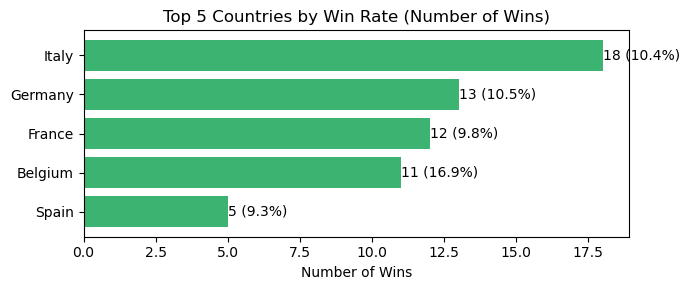

STATUS COUNT AND FUNNEL ANALYSIS
Total Records: 3000

Status Distribution:


Status,Count,Percentage
Opportunity,867,28.9%
Qualified,567,18.9%
Sales Accepted,528,17.6%
New,513,17.1%
Churned Customer,177,5.9%
Disqualified,177,5.9%
Customer,171,5.7%


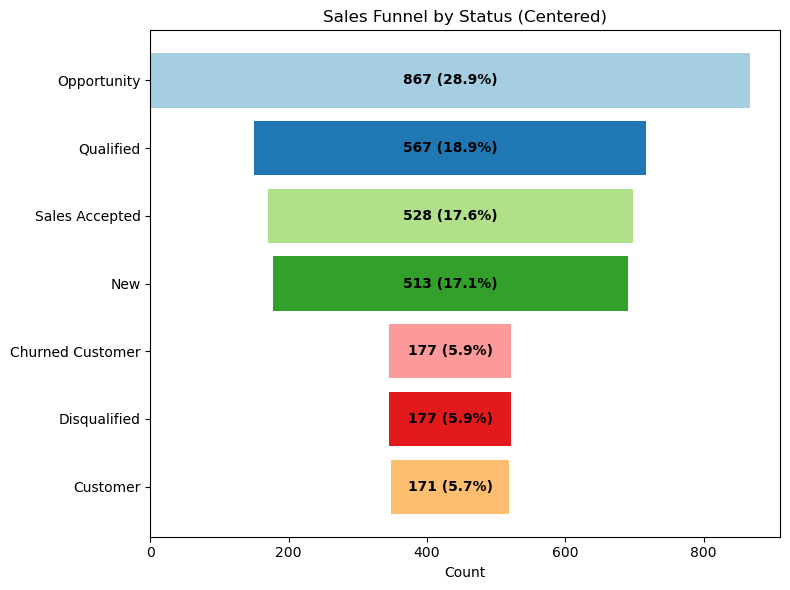

In [13]:
import pandas as pd
from IPython.display import display, HTML

# Filter for opportunities (where Stage is not null)
opps_df = df[df['Stage'].notnull()]

# Filter for wins
wins_df = df[df['Stage'].str.lower() == 'won']

# Total number of wins and opportunities
total_wins = wins_df.shape[0]
total_opps = opps_df.shape[0]

# Overall win rate percentage
win_rate = (total_wins / total_opps) * 100

print(f"Total Wins: {total_wins}")
print(f"Overall Win Rate: {win_rate:.1f}%")

# Top 3 countries by number of wins
country_wins = wins_df['Country'].value_counts().reset_index()
country_wins.columns = ['Country', 'Wins']

# Number of opportunities per country
country_opps = opps_df['Country'].value_counts().reset_index()
country_opps.columns = ['Country', 'Opportunities']

# Merge and calculate win rate per country
country_stats = pd.merge(country_wins, country_opps, on='Country')
country_stats['Win Rate'] = (country_stats['Wins'] / country_stats['Opportunities']) * 100
country_stats['Win Rate'] = country_stats['Win Rate'].map('{:.1f}%'.format)

# Reorder columns: Country, Opportunities, Wins, Win Rate
country_stats = country_stats[['Country', 'Opportunities', 'Wins', 'Win Rate']]

# Sort by win rate descending (need numeric sort, so recalculate)
country_stats['Win Rate (num)'] = (country_stats['Wins'] / country_stats['Opportunities']) * 100
country_stats = country_stats.sort_values('Win Rate (num)', ascending=False).head(5).reset_index(drop=True)
country_stats = country_stats.drop(columns=['Win Rate (num)'])

# Center all columns and remove index
styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]

display(HTML(country_stats.style.set_table_styles(styles).hide(axis='index').to_html()))



import matplotlib.pyplot as plt

# Sort by number of wins descending for the plot
plot_data = country_stats.sort_values('Wins', ascending=False)

plt.figure(figsize=(7, 3))
plt.barh(plot_data['Country'], plot_data['Wins'], color='mediumseagreen')
plt.xlabel('Number of Wins')
plt.title('Top 5 Countries by Win Rate (Number of Wins)')
for i, (wins, rate) in enumerate(zip(plot_data['Wins'], plot_data['Win Rate'])):
    plt.text(wins, i, f'{wins} ({rate})', va='center', fontsize=10)
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()



# STATUS COUNT AND FUNNEL GRAPH ANALYSIS
print("="*50)
print("STATUS COUNT AND FUNNEL ANALYSIS")
print("="*50)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

# Count all status values in the dataset
status_counts = df['Status'].value_counts().reset_index()
status_counts.columns = ['Status', 'Count']

# Calculate percentage of each status
total_records = len(df)
status_counts['Percentage'] = (status_counts['Count'] / total_records) * 100
status_counts['Percentage'] = status_counts['Percentage'].map('{:.1f}%'.format)

# Reorder columns
status_counts = status_counts[['Status', 'Count', 'Percentage']]

# Display the status counts table
print(f"Total Records: {total_records}")
print("\nStatus Distribution:")
display(HTML(status_counts.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).hide(axis='index').to_html()))

# Centered funnel chart
plt.figure(figsize=(8, 6))
status_counts_funnel = status_counts.sort_values('Count', ascending=False)
y_positions = np.arange(len(status_counts_funnel))
widths = status_counts_funnel['Count']

# Calculate the maximum width for centering
max_width = widths.max()
lefts = (max_width - widths) / 2  # This will center each bar

for i, (left, width) in enumerate(zip(lefts, widths)):
    plt.barh(i, width, left=left, color=plt.cm.Paired.colors[i % len(plt.cm.Paired.colors)])

plt.yticks(y_positions, status_counts_funnel['Status'])
plt.xlabel('Count')
plt.title('Sales Funnel by Status (Centered)')
plt.gca().invert_yaxis()

for i, (count, percentage, left) in enumerate(zip(status_counts_funnel['Count'], status_counts_funnel['Percentage'], lefts)):
    plt.text(left + count / 2, i, f'{count} ({percentage})', va='center', ha='center', fontweight='bold', color='black')

plt.tight_layout()
plt.show()

## Product-Market Optimization

**Question:**  
Which products offer the highest revenue potential?

**Approach:**  
By analyzing the current pipeline and focusing only on opportunities (`Status == "Opportunity"`), I found that the highest revenue potential is concentrated in the following products:

- The analysis was performed by grouping all opportunities by product and summing their total deal value.
- Only the `Product`, `Status`, and `Deal_Value_USD` columns were used.
- The results show that, at present, there are only three products with active opportunities in the pipeline. These products represent the areas with the greatest potential for future wins, based on the current data.

This insight can help prioritize sales and marketing efforts toward the products with the largest opportunity value in the pipeline.

In [14]:
# Filter for opportunities (where Product is not null)
opps_df = df[(df['Status'] == 'Opportunity') & (df['Product'].notnull())]

# Total number of opportunities and total deal value
num_opps = opps_df.shape[0]
total_value = opps_df['Deal_Value_USD'].sum()

# Function to format currency in $12K, $1M, etc.
def currency_format(x):
    if x >= 1_000_000:
        return f'${x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'${x/1_000:.0f}K'
    else:
        return f'${x:,.0f}'

print(f"Total Opportunities: {num_opps}")
print(f"Total Opportunity Value: {currency_format(total_value)}")

# Top 3 products by opportunity value
product_totals = opps_df.groupby('Product')['Deal_Value_USD'].sum().reset_index()
product_totals = product_totals.sort_values('Deal_Value_USD', ascending=False).head(3).reset_index(drop=True)
product_totals['Deal Value (USD)'] = product_totals['Deal_Value_USD'].apply(currency_format)
product_totals = product_totals[['Product', 'Deal Value (USD)']]

# Center all columns and remove index
styles = [
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]

from IPython.display import display, HTML
display(HTML(product_totals.style.set_table_styles(styles).hide(axis='index').to_html()))


Total Opportunities: 867
Total Opportunity Value: $2.3M


Product,Deal Value (USD)
SAAS,$961K
Services,$847K
Custom solution,$488K
